In [32]:
import pandas as pd

# acled.ipynb - https://api.acleddata.com/acled/read
df = pd.read_csv('acled-ua-war-2022-2024-page-28.csv')
df.head(2)

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,UKR184294,2024-09-20,2024,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),NaN,External/Other forces,...,Antonivka,46.6799,32.6925,2,Ministry of Defence of Russia,National,"On 20 September 2024, Russian Forces struck (l...",2,NaN,1727205008
1,UKR184295,2024-09-20,2024,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),Military Forces of Russia (2000-) Air Force,External/Other forces,...,Bila Hora,48.4837,37.8688,2,Institute for the Study of War; Ministry of De...,Other-National,"On 20 September 2024, Russian Forces, supporte...",1,NaN,1727205008


In [33]:
# https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?flg=en-us
world_admin_df = pd.read_csv('world-administrative-boundaries.csv', sep=';')
world_admin_df.head()

,Geo Point,Geo Shape,ISO 3 territory code,Status,ISO 3 country code,English Name,Continent of the territory,Region of the territory,ISO 3166-1 Alpha 2-Codes,French Name
0,"1.2799634451787583, 32.38621827281175","{""coordinates"": [[[33.92110000000008, -1.00193...",UGA,Member State,UGA,Uganda,Africa,Eastern Africa,UG,Ouganda
1,"41.75044402910113, 63.169364370421164","{""coordinates"": [[[70.97081000000009, 42.25467...",UZB,Member State,UZB,Uzbekistan,Asia,Central Asia,UZ,Ouzbékistan
2,"53.1763816282643, -8.150578960214018","{""coordinates"": [[[[-9.970139999999958, 54.020...",IRL,Member State,IRL,Ireland,Europe,Northern Europe,IE,Irlande
3,"15.373203130370355, 38.84128573461554","{""coordinates"": [[[[40.135830000000055, 15.752...",ERI,Member State,ERI,Eritrea,Africa,Eastern Africa,ER,Érythrée
4,"21.892740179494872, 33.74379108021756","{""coordinates"": [[[33.251040000000046, 21.9997...",NaN,Adm. by EGY,EGY,Ma'tan al-Sarra,Africa,Northern Africa,NaN,Ma'tan al-Sarra


In [34]:
import json
import folium

uaborder = json.loads(world_admin_df[world_admin_df['English Name']=='Ukraine'].iloc[0]['Geo Shape'])['coordinates'][0]
lat, lon = zip(*uaborder)
uaborderdf = pd.DataFrame({'lat':lat, 'lon':lon})

def geoplot(df_: pd.DataFrame, latname='lat', lonname='lon', popupname='lat', title=None):
  m = folium.Map(location=[df_[latname].mean(), df_[lonname].mean()], zoom_start=6)
  for _, row in df_.iterrows(): folium.Marker(location=[row[latname], row[lonname]], popup=row[popupname]).add_to(m)
  title_html = f'''<h3 align="center" style="font-size:20px"><b>{title}</b></h3>''' if title else ''
  m.get_root().html.add_child(folium.Element(title_html))
  return m

geoplot(df_=uaborderdf.iloc[::10],latname='lon',lonname='lat',title='BORDER')

In [35]:
filtered_df.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')

In [36]:
filtered_df = df[(df['event_date'] == '2022-02-24') & 
                 (df['event_type'] == 'Battles')
                 ]

geoplot(df_=filtered_df,latname='latitude',lonname='longitude',popupname='notes',title='INVASION')

In [37]:
def read_shapefile(shp_path):
	import shapefile
	import pandas as pd

	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records =[list(i) for i in sf.records()]
	shps = [s.points for s in sf.shapes()]

	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)
	return df

# https://data.humdata.org/dataset/ukraine-border-crossings?
uabordcrossdf = read_shapefile(shp_path='ua-border-cross/ua-border-cross.shp')
uabordcrossdf.head(3)

,Name_ENG,Name_UKR,Country,Type,Status,Lat,Lon,StatusAsOf,coords
0,Yahodyn - Dorohusk,Ягодин - Дорогуськ,Poland,Road,Operational,51.187826,23.810660,2024-06-06,"[[23.81066001661428, 51.18782601820227]]"
1,Uhryniv - Dołhobyczów,Угринів - Долгобичув,Poland,Road,Operational,50.578049,24.090431,2024-06-06,"[[24.090430730839955, 50.57804863747064]]"
2,Ustyluh - Zosin,Устилуг - Зосін,Poland,Road,Operational,50.856125,24.143328,2024-06-06,"[[24.143327865871857, 50.8561247463687]]"


In [38]:
geoplot(df_=uabordcrossdf,latname='Lat',lonname='Lon',popupname='Name_ENG',title='CROSSING')


In [39]:
import osmnx as ox

# https://openstreetbrowser.org/#map=9/50.6416/30.5351&basemap=osm-mapnik&categories=roads
place_name = "Kyiv Oblast, Ukraine"

G = ox.graph_from_place(place_name, network_type='drive')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()

/Users/antonvice/Downloads/Telegram Desktop/nasa-hackathon-initial-files/.venv/lib/python3.12/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


osmid       ref      highway  oneway reversed  \
u         v           key                                                      
337492961 2137570875  0    398226781  О-102302     tertiary   False    False   
414239917 6936958294  0    391587218       NaN  residential   False    False   
          10683237730 0    403695256      Р-17      primary   False    False   
          10778823856 0    403695256      Р-17      primary   False     True   
414240090 4060295156  0    403704791      Р-17      primary   False    False   

                             length  \
u         v           key             
337492961 2137570875  0    2128.998   
414239917 6936958294  0     101.402   
          10683237730 0      75.526   
          10778823856 0     175.131   
414240090 4060295156  0     172.275   

                                                                    geometry  \
u         v           key                                                      
337492961 2137570875  0    LINESTRING (29.92080 49.23015, 29.91202 49.232...   
414239917 6936958294  0    LINESTRING (29.66897 49.37598, 29.66864 49.376...   
          10683237730 0    LINESTRING (29.66897 49.37598, 29.66904 49.375...   
          10778823856 0    LINESTRING (29.66897 49.37598, 29.66891 49.376...   
414240090 4060295156  0    LINESTRING (29.67601 49.43146, 29.67509 49.431...   

                                                   name lanes bridge maxspeed  \
u         v           key                                                       
337492961 2137570875  0                             NaN   NaN    NaN      NaN   
414239917 6936958294  0                             NaN   NaN    NaN      NaN   
          10683237730 0               Центральна вулиця   NaN    NaN      NaN   
          10778823856 0               Центральна вулиця   NaN    NaN      NaN   
414240090 4060295156  0    вулиця Богдана Хмельницького     2    NaN      NaN   

                          width junction access tunnel  
u         v           key                               
337492961 2137570875  0     NaN      NaN    NaN    NaN  
414239917 6936958294  0     NaN      NaN    NaN    NaN  
          10683237730 0     NaN      NaN    NaN    NaN  
          10778823856 0     NaN      NaN    NaN    NaN  
414240090 4060295156  0     NaN      NaN    NaN    NaN

Re-route invasion
1. most likely invasion routes + prevention
- https://data.humdata.org/dataset/ukraine-border-crossings
- https://data.humdata.org/group/ukr?q=infra&sort=last_modified%20desc&ext_page_size=25
- Digital elevation model
- https://acleddata.com/explorer/
6. natural/urban features that can slow down/stop an invading force
8. where war most likely to spill to populated areas - develop evacuation/defense plans

In [40]:
m = geoplot(df_=filtered_df,latname='latitude',lonname='longitude',popupname='notes',title='INVASION')
for _, edge in gdf_edges.head(100).iterrows():
  locs = [(point[1], point[0]) for point in edge.geometry.coords]
  line = folium.PolyLine(locations=locs, color='blue', weight=2.5)
  line.add_to(m)
m

In [41]:
"abc"[0:1]

'a'

In [42]:
import pystac
import planetary_computer
import rioxarray

# https://planetarycomputer.microsoft.com/explore?c=30.7412%2C50.3984&z=6.30&v=2&d=cop-dem-glo-30&m=Most+recent&r=Hillshade&s=false%3A%3A29%3A%3Atrue&sr=desc&ae=0
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30/items/Copernicus_DSM_COG_10_N51_00_E030_00_DEM"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets 
asset_href = signed_item.assets["data"].href
ds = rioxarray.open_rasterio(asset_href)
ds


ModuleNotFoundError: No module named 'numpy.char'

In [43]:
import pystac
import planetary_computer
import rioxarray

# https://planetarycomputer.microsoft.com/explore?c=31.1900%2C50.8164&z=5.94&v=2&d=modis-13Q1-061&m=Most+recent&r=Normalized+difference+vegetation+index+%28NDVI%29+16-day&s=false%3A%3A50%3A%3Atrue&sr=desc&ae=0
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/modis-13Q1-061/items/MYD13Q1.A2024249.h19v03.061.2024268131753"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: '250m_16_days_NDVI', '250m_16_days_VI_Quality', '250m_16_days_MIR_reflectance', '250m_16_days_NIR_reflectance', '250m_16_days_red_reflectance', '250m_16_days_blue_reflectance', '250m_16_days_sun_zenith_angle', '250m_16_days_pixel_reliability', '250m_16_days_view_zenith_angle', '250m_16_days_relative_azimuth_angle', '250m_16_days_composite_day_of_the_year')
asset_href = signed_item.assets["250m_16_days_EVI"].href
ds = rioxarray.open_rasterio(asset_href)
ds



ModuleNotFoundError: No module named 'numpy.char'

In [ ]:
!uv pip install geopandas rioxarray osmnx shapely fiona

Audited 5 packages in 17ms


In [46]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming filtered_df is your conflict DataFrame with 'latitude', 'longitude', and 'notes' columns

# Ensure the conflict DataFrame contains the necessary columns
if 'latitude' in filtered_df.columns and 'longitude' in filtered_df.columns:
    
    # Create a 'geometry' column from the latitude and longitude
    geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
    
    # Convert to a GeoDataFrame
    conflict_gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry, crs="EPSG:4326")
    
    # Check the result
    print(conflict_gdf.head())
else:
    print("The conflict DataFrame is missing 'latitude' or 'longitude' columns.")

       event_id_cnty  event_date  year  time_precision       disorder_type  \
132152      UKR52170  2022-02-24  2022               1  Political violence   
132154      UKR52175  2022-02-24  2022               1  Political violence   
132155      UKR52178  2022-02-24  2022               1  Political violence   
132157      UKR52184  2022-02-24  2022               1  Political violence   
132159      UKR52197  2022-02-24  2022               1  Political violence   

       event_type                       sub_event_type  \
132152    Battles  Non-state actor overtakes territory   
132154    Battles                          Armed clash   
132155    Battles  Non-state actor overtakes territory   
132157    Battles  Non-state actor overtakes territory   
132159    Battles  Non-state actor overtakes territory   

                                             actor1 assoc_actor_1  \
132152            Military Forces of Russia (2000-)           NaN   
132154  Military Forces of Russia (2000-) Ai

In [44]:
import shapefile
import pandas as pd

# Function to read shapefiles and convert them to a pandas DataFrame
def read_shapefile(shp_path):
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]  # Skip 'DeletionFlag'
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    
    # Ensure that the shapefile shapes are valid and have at least one point
    valid_shps = [s[0] if len(s) > 0 else None for s in shps]  # Get the first point of each shape if it exists
    
    # Create a DataFrame with fields and records
    df = pd.DataFrame(columns=fields, data=records)
    
    # Assign coordinates to the DataFrame (handling invalid entries)
    df = df.assign(coords=valid_shps)
    
    # Drop rows where the coords are None
    df = df.dropna(subset=['coords'])
    
    return df

# Load blockpost shapefile data and print head to verify
uabordcrossdf = read_shapefile(shp_path='ua-border-cross/ua-border-cross.shp')
print(uabordcrossdf.head())

# Now convert blockpost data into a GeoDataFrame with geometry (if coords are valid)
uabordcrossdf['Lat'] = uabordcrossdf['coords'].apply(lambda x: x[1] if len(x) > 1 else None)
uabordcrossdf['Lon'] = uabordcrossdf['coords'].apply(lambda x: x[0] if len(x) > 0 else None)

# Drop any rows where Lat or Lon is None (invalid data)
uabordcrossdf = uabordcrossdf.dropna(subset=['Lat', 'Lon'])

# Convert to GeoDataFrame for further analysis
import geopandas as gpd
blockpost_gdf = gpd.GeoDataFrame(
    uabordcrossdf, geometry=gpd.points_from_xy(uabordcrossdf['Lon'], uabordcrossdf['Lat']), crs="EPSG:4326"
)

# Print blockpost GeoDataFrame
print(blockpost_gdf.head())

                Name_ENG                Name_UKR Country  Type       Status  \
0     Yahodyn - Dorohusk      Ягодин - Дорогуськ  Poland  Road  Operational   
1  Uhryniv - Dołhobyczów    Угринів - Долгобичув  Poland  Road  Operational   
2        Ustyluh - Zosin         Устилуг - Зосін  Poland  Road  Operational   
3  Rava-Ruska - Hrebenne  Рава-Руська - Хребенне  Poland  Road  Operational   
4   Krakivets - Korczowa     Краківець - Корчова  Poland  Road  Operational   

         Lat        Lon  StatusAsOf                                   coords  
0  51.187826  23.810660  2024-06-06   [23.81066001661428, 51.18782601820227]  
1  50.578049  24.090431  2024-06-06  [24.090430730839955, 50.57804863747064]  
2  50.856125  24.143328  2024-06-06   [24.143327865871857, 50.8561247463687]  
3  50.273385  23.589823  2024-06-06   [23.58982299337393, 50.27338487703146]  
4  49.954611  23.116259  2024-06-06    [23.11625927889091, 49.9546105980822]  
                Name_ENG                Name_UKR Co

In [47]:
import folium
import geopandas as gpd

# Assuming `blockpost_gdf` contains blockpost data and `conflict_gdf` contains conflict zones data

def create_map(blockpost_gdf, conflict_gdf):
    # Calculate the center of the map
    map_center_lat = conflict_gdf['geometry'].y.mean()
    map_center_lon = conflict_gdf['geometry'].x.mean()
    
    # Create a Folium map centered around the conflict zone and blockpost data
    m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7)

    # Add blockposts to the map
    for _, row in blockpost_gdf.iterrows():
        folium.Marker(
            location=[row['Lat'], row['Lon']],
            popup=f"Blockpost: {row['Name_ENG']}",
            icon=folium.Icon(color="blue", icon="shield")
        ).add_to(m)

    # Add conflict zones to the map
    for _, row in conflict_gdf.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"Conflict: {row['notes']}",
            icon=folium.Icon(color="red", icon="exclamation-triangle")
        ).add_to(m)

    # Display the map
    return m

# Create the map with blockposts and conflict zones
map_with_blockposts_and_conflicts = create_map(blockpost_gdf, conflict_gdf)

# Show the map in the notebook (for Jupyter environment)
map_with_blockposts_and_conflicts

In [49]:
from shapely.geometry import LineString

# Create lines between conflict zones and nearest blockposts
def create_battlefield_lines(conflict_gdf):
    battlefield_lines = []
    
    for i, row in conflict_gdf.iterrows():
        conflict_point = row.geometry
        blockpost_point = row['nearest_blockpost']
        
        # Create a LineString connecting the conflict point and the nearest blockpost
        line = LineString([conflict_point, blockpost_point])
        battlefield_lines.append(line)
    
    return gpd.GeoDataFrame(geometry=battlefield_lines, crs="EPSG:4326")

# Create battlefield lines
battlefield_gdf = create_battlefield_lines(conflict_gdf)

# Function to create the map with blockposts, conflict zones, and battlefield lines
def create_battlefield_map(blockpost_gdf, conflict_gdf, battlefield_gdf):
    # Calculate the center of the map
    map_center_lat = conflict_gdf['geometry'].y.mean()
    map_center_lon = conflict_gdf['geometry'].x.mean()
    
    # Create a Folium map centered around the conflict zone and blockpost data
    m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7)

    # Add blockposts to the map
    for _, row in blockpost_gdf.iterrows():
        folium.Marker(
            location=[row['Lat'], row['Lon']],
            popup=f"Blockpost: {row['Name_ENG']}",
            icon=folium.Icon(color="blue", icon="shield")
        ).add_to(m)

    # Add conflict zones to the map
    for _, row in conflict_gdf.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"Conflict: {row['notes']}",
            icon=folium.Icon(color="red", icon="exclamation-triangle")
        ).add_to(m)
    
    # Add battlefield lines to the map
    for _, row in battlefield_gdf.iterrows():
        folium.GeoJson(row['geometry'].__geo_interface__, style_function=lambda x: {
            'color': 'green',
            'weight': 2
        }).add_to(m)
    
    return m

# Create the map with blockposts, conflict zones, and battlefield lines
battlefield_map = create_battlefield_map(blockpost_gdf, conflict_gdf, battlefield_gdf)

# Show the map in the notebook (for Jupyter environment)
battlefield_map

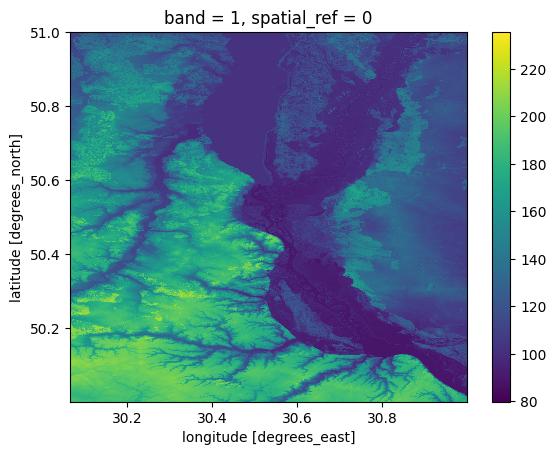

In [60]:
import pystac
import planetary_computer
import rioxarray
# URL to the correct Copernicus DEM data (adjust to the area that matches your bounding box)
dem_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30/items/Copernicus_DSM_COG_10_N50_00_E030_00_DEM"

# Use pystac to fetch the STAC item
item = pystac.Item.from_file(dem_url)

# Sign the item with Microsoft Planetary Computer
signed_item = planetary_computer.sign(item)

# Open the DEM data
dem = rioxarray.open_rasterio(signed_item.assets['data'].href)

# Clip the DEM using your bounding box
minx, miny, maxx, maxy = conflict_gdf.total_bounds
dem_clipped = dem.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

# Plot the clipped DEM
dem_clipped.plot()

In [57]:
print(conflict_gdf.total_bounds)
print(dem.rio.crs)
print(conflict_gdf.crs)
conflict_gdf = conflict_gdf.to_crs(dem.rio.crs)

[30.0656 45.2549 40.1322 51.5055]
EPSG:4326
EPSG:4326


In [62]:
import osmnx as ox
import folium

# Get bounding box from conflict zones (or you can manually define it)
north, south, east, west = conflict_gdf.total_bounds[3], conflict_gdf.total_bounds[1], conflict_gdf.total_bounds[2], conflict_gdf.total_bounds[0]

# Download road network from OpenStreetMap for the region
G = ox.graph_from_bbox(north, south, east, west, network_type='all')

# Convert road network to GeoDataFrame
roads_gdf = ox.graph_to_gdfs(G, nodes=False)

# Check the first few rows to ensure roads data is loaded
print(roads_gdf.head())

/var/folders/6f/3q_n8zpd3qs49lg8rspgc7d80000gn/T/ipykernel_42916/1071398821.py:8: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='all')
/var/folders/6f/3q_n8zpd3qs49lg8rspgc7d80000gn/T/ipykernel_42916/1071398821.py:8: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='all')
/Users/antonvice/Downloads/Telegram Desktop/nasa-hackathon-initial-files/.venv/lib/python3.12/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 207 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_p

In [ ]:
# Overlay road data (GeoJSON) onto your existing map
folium.GeoJson(roads_gdf).add_to(battlefield_map)

# Show the updated map with DEM and road networks
battlefield_map

NameError: name 'roads_gdf' is not defined